# <font color='blue'>Business Analytics</font>

# <font color='blue'>Capítulo 13 - Supply Chain Analytics</font>
## <font color='blue'>Mini-Projeto 8</font>
### <font color='blue'>Prevendo Riscos em Supply Chain Usando Regras de Associação e Multiclass Classification com PySpark</font>

![title](imagens/mini-projeto8.png)

## Definição do Problema

**Qual o risco no atraso de entrega de produtos após a compra?**

Leia o manual em pdf no Capítulo 13 do curso para mais detalhes.

## Fonte de Dados

Leia o manual em pdf no Capítulo 13 do curso.

## Instalando e Carregando os Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
# Instala PySpark 
!pip install -q pyspark

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, round
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Versions" --iversions

Author: Versions

seaborn   : 0.11.2
matplotlib: 3.5.2
numpy     : 1.21.5
pyspark   : 3.3.2
pandas    : 1.4.4



## Etapa 1 - Análise Exploratória

### Carregando os Dados

In [5]:
# Carrega os dados
dados = pd.read_csv("dados/DataCoSupplyChainDataset.csv", encoding = 'latin1')

In [6]:
# Shape
dados.shape

(180519, 53)

In [7]:
# Colunas
dados.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [8]:
# Amostra de dados
dados.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [9]:
# Info
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [10]:
# Verificando valores ausentes
dados.apply(lambda x: sum(x.isnull()))

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [11]:
# Criação de uma nova coluna para o nome do cliente adicionando colunas de nome e sobrenome do cliente
dados['Customer Name'] = dados['Customer Fname'].astype(str) + dados['Customer Lname'].astype(str)

In [12]:
# Amostra de dados
dados.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,Customer Name
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class,CallyHolloway
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class,IreneLuna
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class,GillianMaldonado
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class,TanaTate
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class,OrliHendricks


In [13]:
# Removendo colunas que parecem não ser necessárias
dados = dados.drop(['Product Status',
                    'Customer Password',
                    'Customer Email',
                    'Customer Street',
                    'Customer Fname',
                    'Customer Lname',
                    'Latitude',
                    'Longitude',
                    'Product Image',
                    'Product Description',
                    'Order Zipcode',
                    'shipping date (DateOrders)'],
                   axis = 1)

In [14]:
# Shape
dados.shape

(180519, 42)

In [15]:
# Vamos atribuir o valor zero para os valores ausentes da coluna 'Customer Zipcode'
dados['Customer Zipcode'] = dados['Customer Zipcode'].fillna(0)

In [16]:
# Verificando valores ausentes
dados.apply(lambda x: sum(x.isnull()))

Type                             0
Days for shipping (real)         0
Days for shipment (scheduled)    0
Benefit per order                0
Sales per customer               0
Delivery Status                  0
Late_delivery_risk               0
Category Id                      0
Category Name                    0
Customer City                    0
Customer Country                 0
Customer Id                      0
Customer Segment                 0
Customer State                   0
Customer Zipcode                 0
Department Id                    0
Department Name                  0
Market                           0
Order City                       0
Order Country                    0
Order Customer Id                0
order date (DateOrders)          0
Order Id                         0
Order Item Cardprod Id           0
Order Item Discount              0
Order Item Discount Rate         0
Order Item Id                    0
Order Item Product Price         0
Order Item Profit Ra

In [17]:
# Tipos de dados
dados.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Delivery Status                   object
Late_delivery_risk                 int64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Id                        int64
Customer Segment                  object
Customer State                    object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Market                            object
Order City                        object
Order Country                     object
Order Customer Id                  int64
order date (DateOrders)           object
Order Id                           int64
Order Item Cardprod Id             int64
Order Item Disco

<AxesSubplot:>

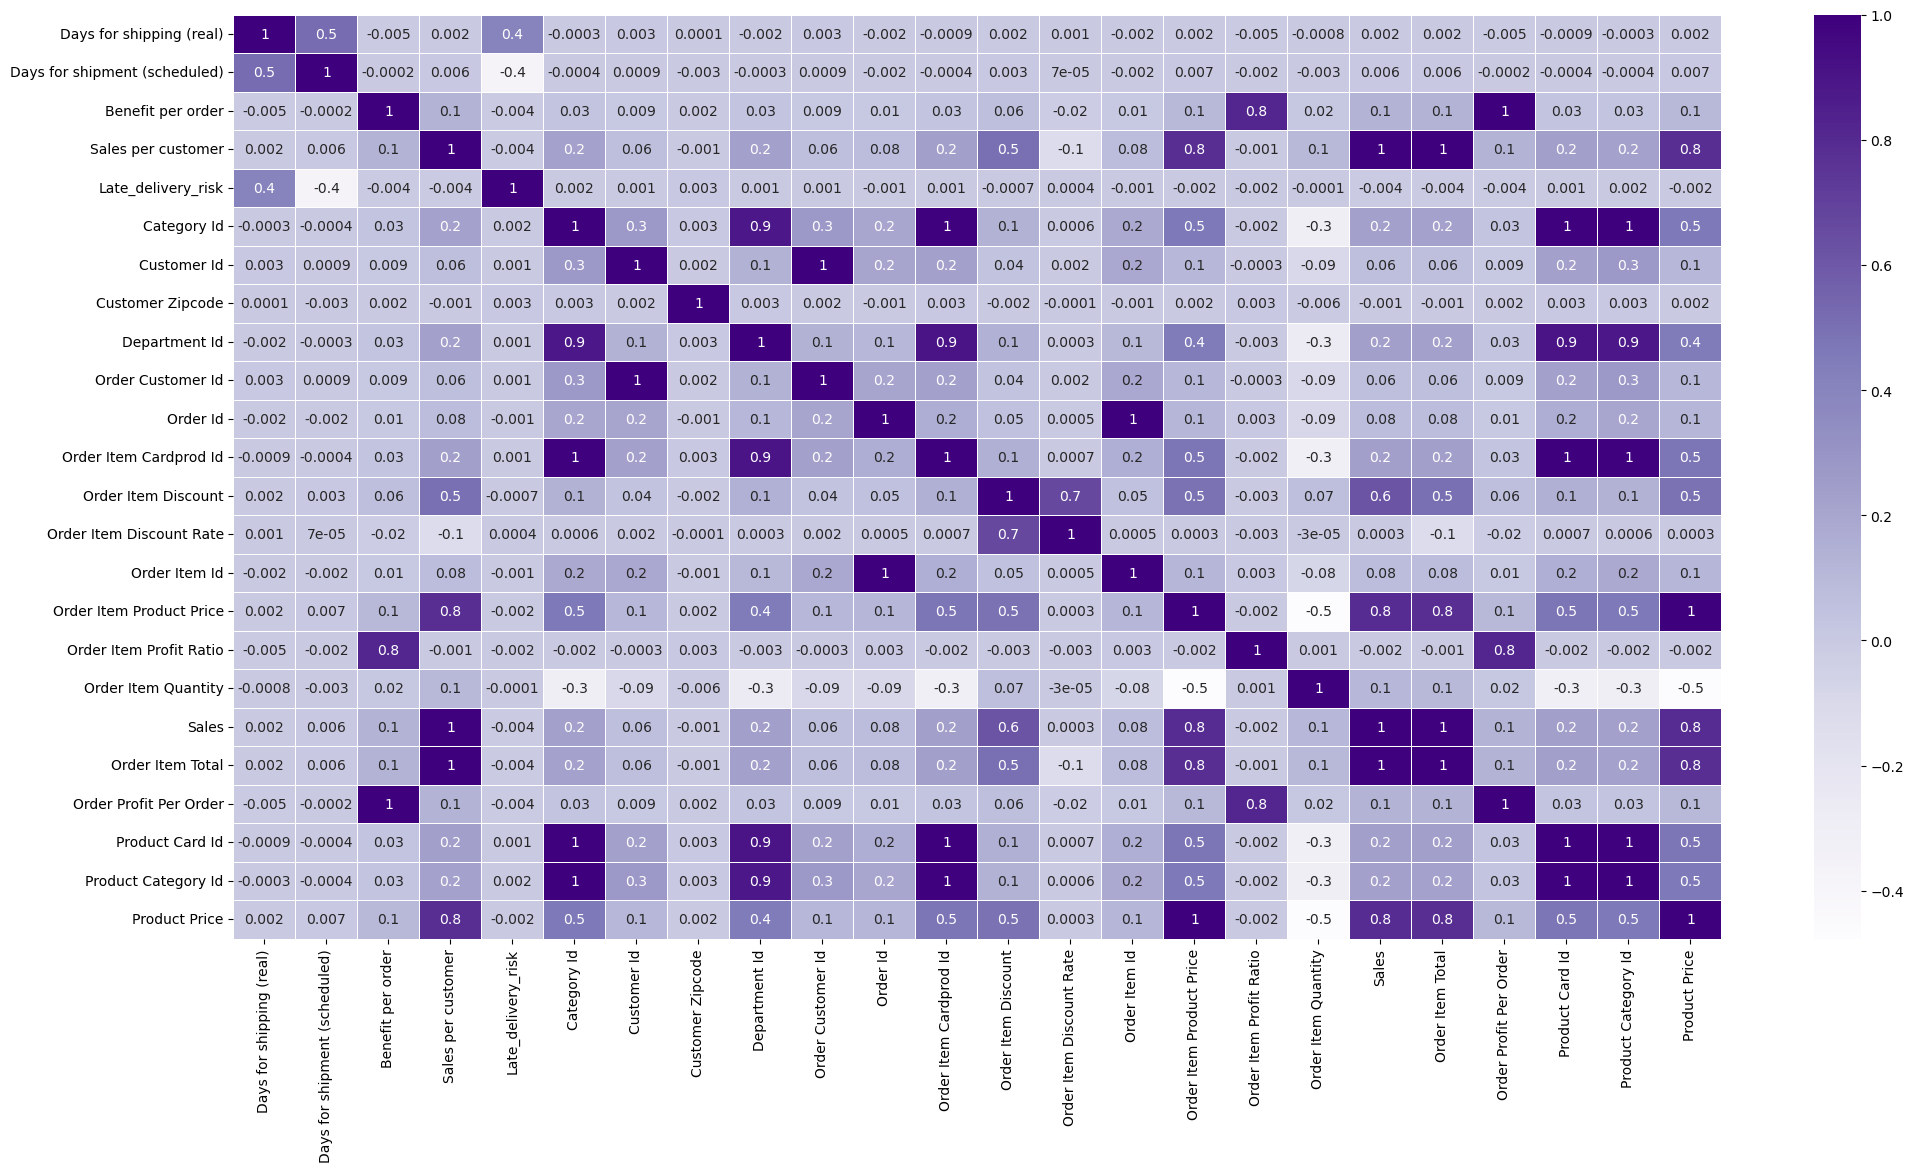

In [18]:
# Matriz de correlação para as variáveis numéricas
fig, ax = plt.subplots(figsize = (24,12))         
sns.heatmap(dados.corr(), annot = True, linewidths = .5, fmt = '.1g', cmap = 'Purples') 

> De acordo com a Matriz de Correlação, podemos ver que o preço do produto tem uma alta correlação com as vendas, total do item do pedido e vendas por cliente. Vamos explorar melhor os dados.

### Vendas Por Região

In [19]:
# Agrupa os dados por continente
grupo_mercado = dados.groupby('Market')

<AxesSubplot:title={'center':'Vendas Por Continente'}, xlabel='Market'>

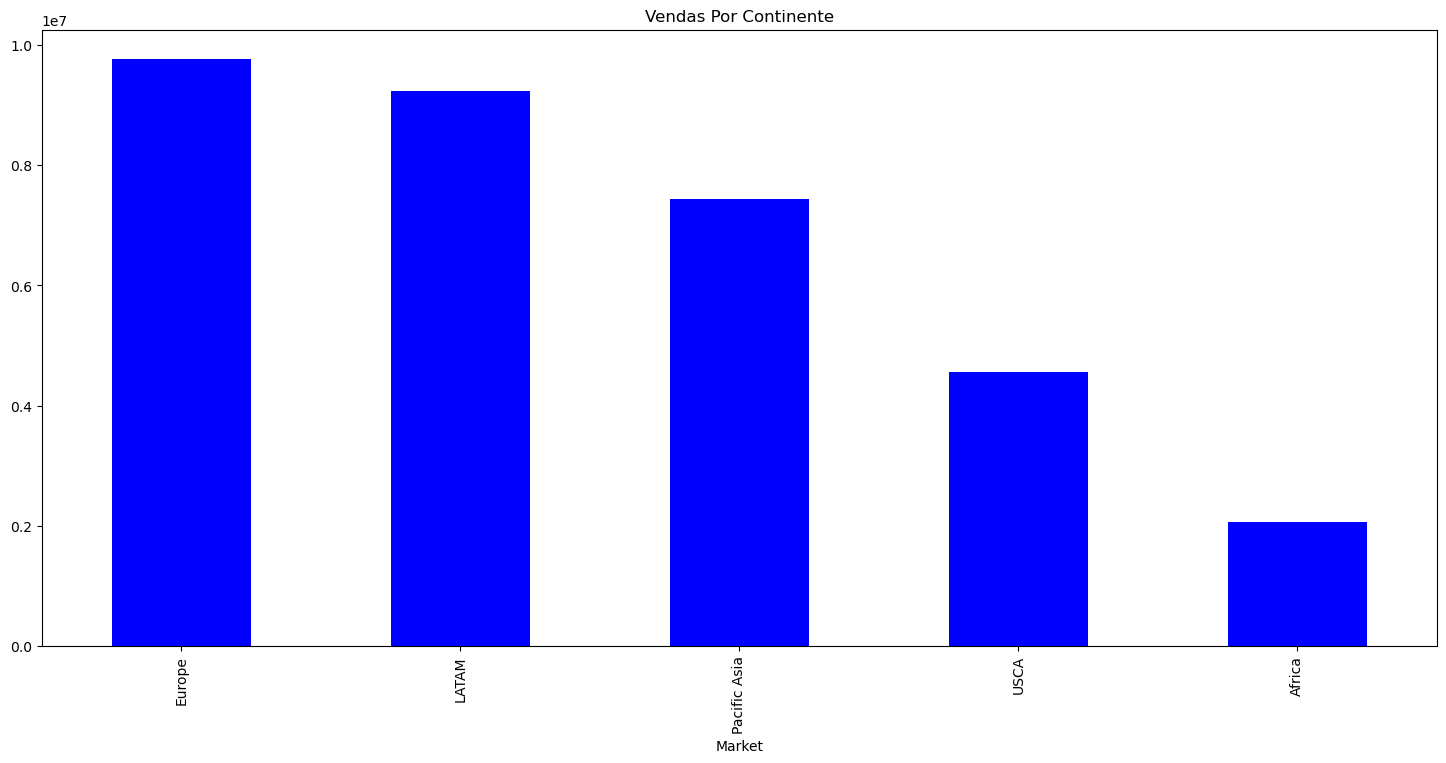

In [20]:
# Plot
plt.figure(1)
grupo_mercado['Sales per customer'].sum().sort_values(ascending = False).plot.bar(figsize = (18,8), 
                                                                                  color  = ['blue'], 
                                                                                  title = "Vendas Por Continente")

Pelo gráfico acima podemos observar que o mercado europeu tem o maior número de vendas enquanto que a África apresenta o menor número de vendas.

In [21]:
# Agrupa por Order Region
grupo_regiao = dados.groupby('Order Region')

<AxesSubplot:title={'center':'Vendas Por Região'}, xlabel='Order Region'>

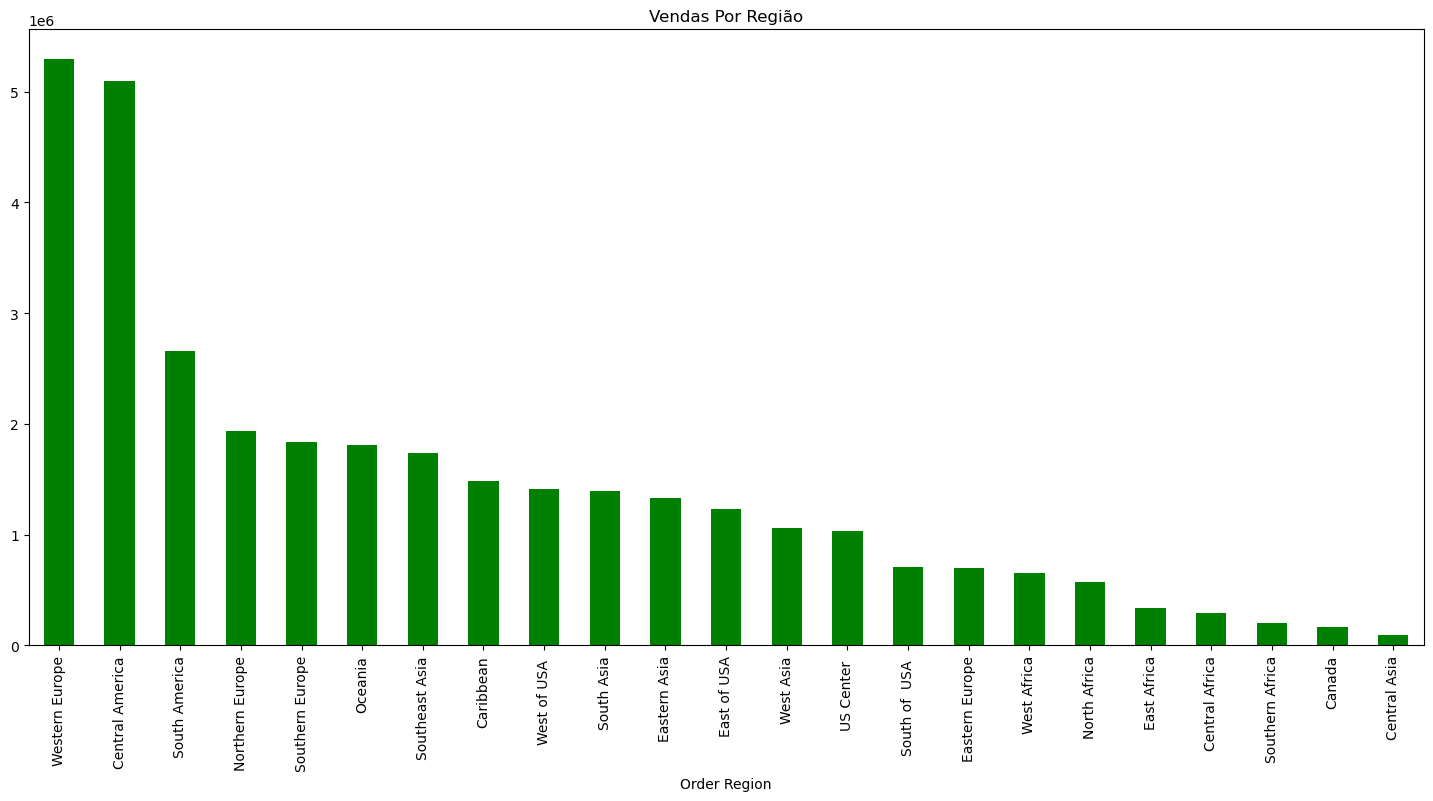

In [22]:
# Plot
plt.figure(2)
grupo_regiao['Sales per customer'].sum().sort_values(ascending = False).plot.bar(figsize = (18,8), 
                                                                                 color = ['green'], 
                                                                                 title = "Vendas Por Região")

No gráfico acima podemos ver que a região da Europa Ocidental e a região da América Central registraram o maior volume de vendas, enquanto a Ásia Central registrou o menor volume de vendas.

### Vendas Por Produto

In [23]:
# Agrupa os dados por categoria
categoria = dados.groupby('Category Name')

<AxesSubplot:title={'center':'Vendas por Categoria'}, xlabel='Category Name'>

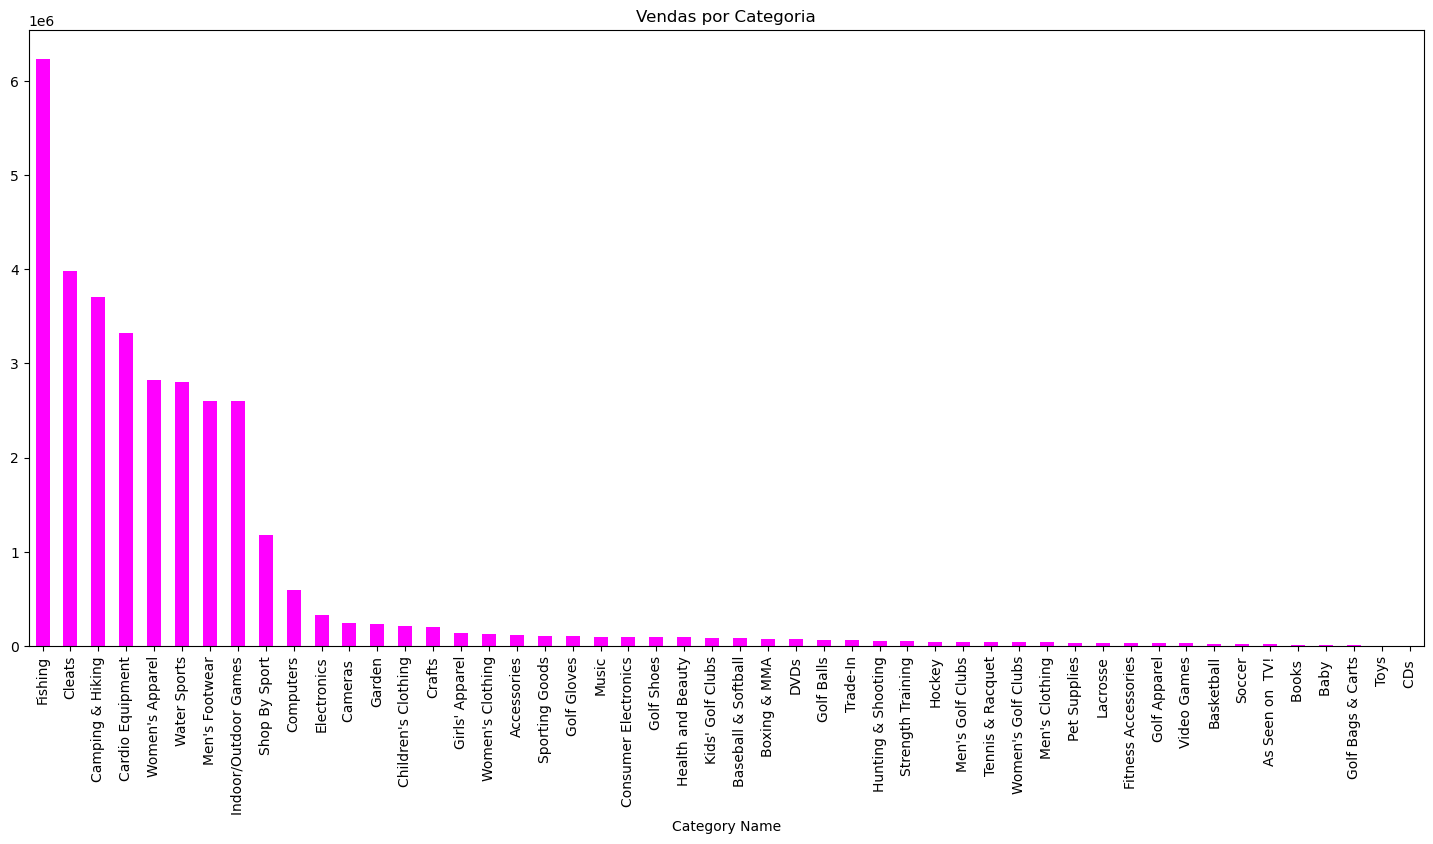

In [24]:
# Plot
plt.figure(1)
categoria['Sales per customer'].sum().sort_values(ascending = False).plot.bar(figsize = (18,8), 
                                                                              color = ['magenta'], 
                                                                              title = "Vendas por Categoria")

Pelo gráfico acima podemos verificar que material de pesca tem o maior número de vendas seguido de chuteiras.

<AxesSubplot:title={'center':'Média de Vendas Por Categoria'}, xlabel='Category Name'>

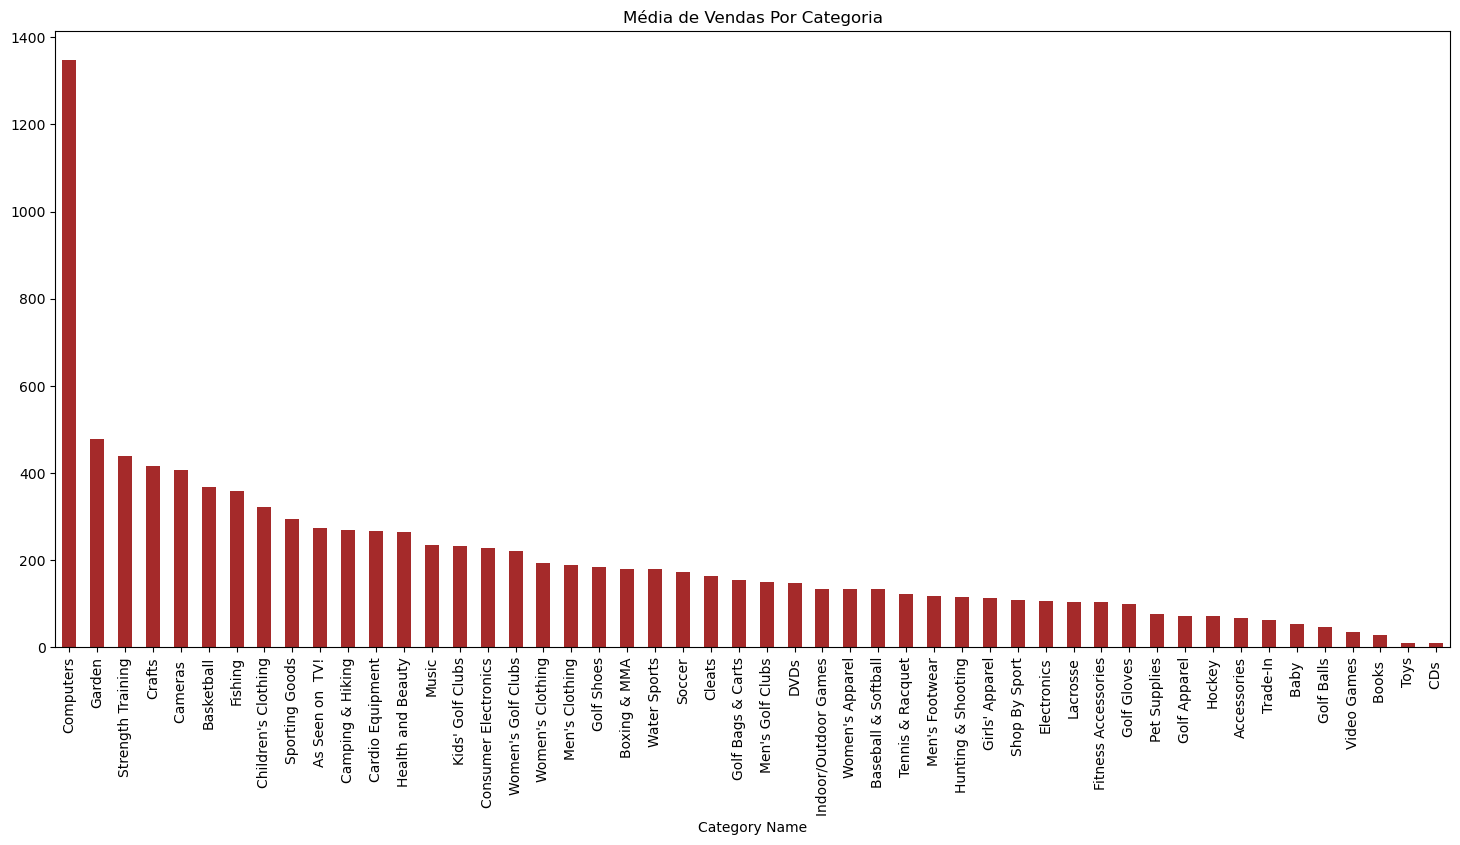

In [25]:
# Vejamos a média de vendas por categoria
plt.figure(2)
categoria['Sales per customer'].mean().sort_values(ascending = False).plot.bar(figsize = (18,8), 
                                                                               color = ['brown'],
                                                                               title = "Média de Vendas Por Categoria")

<AxesSubplot:title={'center':'Preço Médio Por Categoria'}, xlabel='Category Name'>

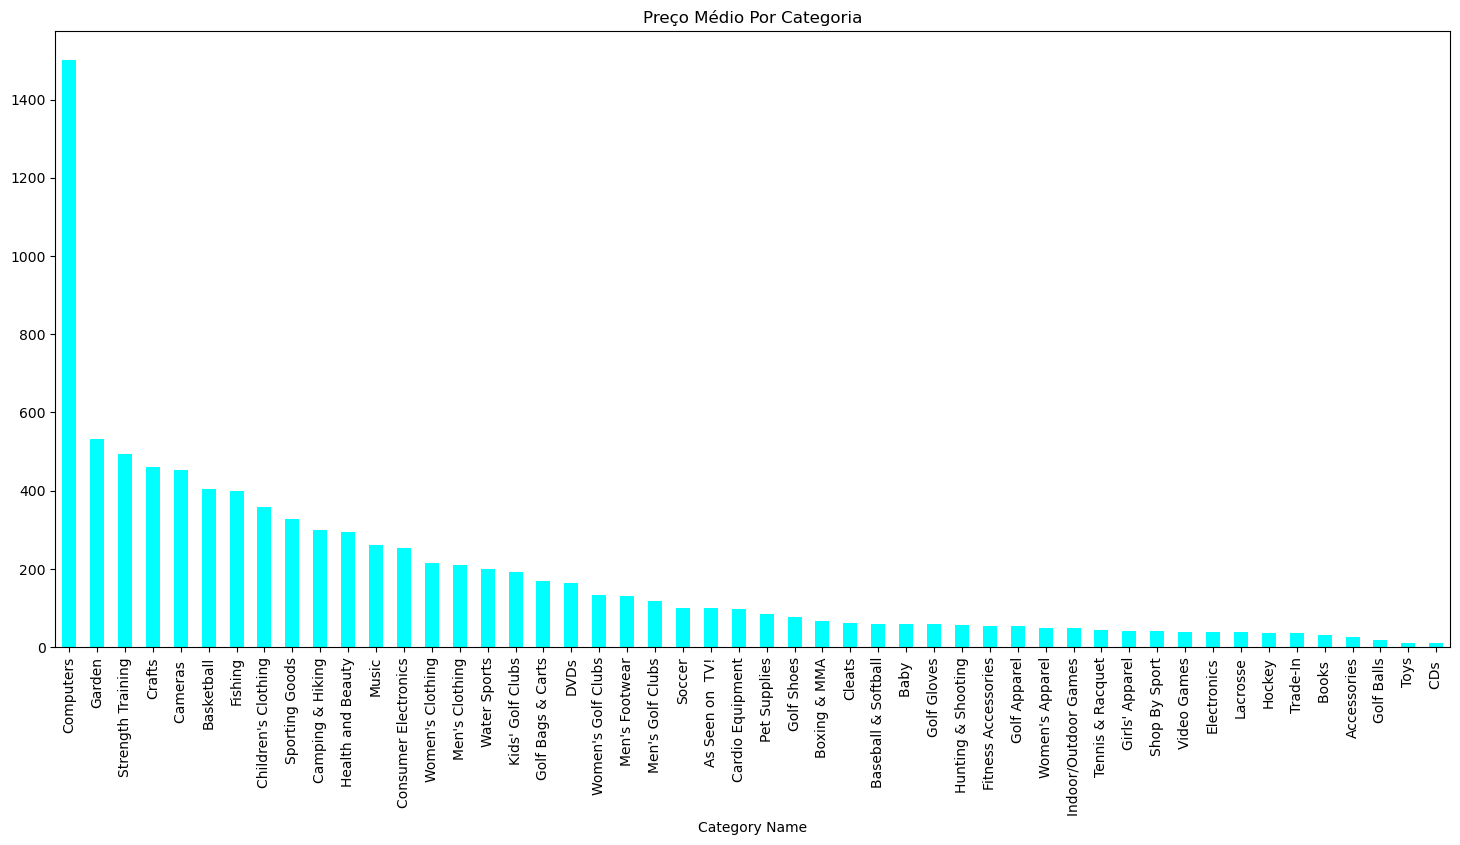

In [26]:
# Preço Médio de venda por categoria
plt.figure(3)
categoria['Product Price'].mean().sort_values(ascending = False).plot.bar(figsize = (18,8), 
                                                                          color = ['cyan'], 
                                                                          title = "Preço Médio Por Categoria")

Podemos observar que os produtos com os preços mais altos, em média, são os que têm, em média, maior volume de vendas. Os computadores vendem cerca de 1.400 unidades, apesar do preço médio de um computador estar perto de US$ 1.500.

Qual será a relação entre preço do produto e unidades vendidas? Vamos descobrir.

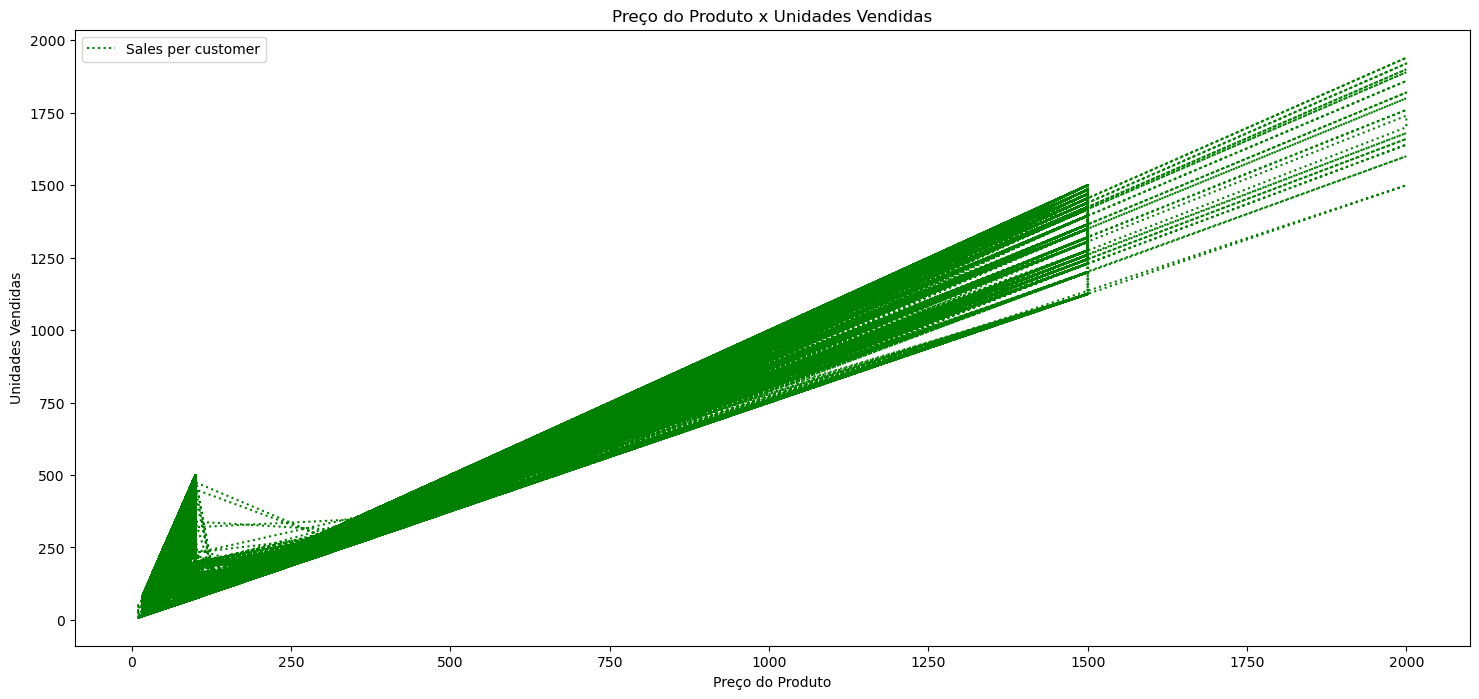

In [27]:
# Plot
dados.plot(x = 'Product Price', 
           y = 'Sales per customer',
           linestyle = 'dotted',
           markerfacecolor = 'blue', 
           markersize = 12, 
           color = ['green'], 
           figsize = (18,8)) 
plt.title('Preço do Produto x Unidades Vendidas')
plt.xlabel('Preço do Produto')
plt.ylabel('Unidades Vendidas') 
plt.show()

Como você pode ver no gráfico acima, o preço do produto tem uma relação linear com as unidades vendidas.

In [28]:
# Vamos salvar os dados processados até aqui
dados.to_csv("dados/DataCoSupplyChainDatasetProcessados.csv")

## Etapa 2 - Regras de Associação

As Regras de Associação representam um dos conceitos mais importantes de aprendizado de máquina usado principalmente na análise de cesta de compras. Ou seja, precisamoos de dados de vendas de produtos.

Em uma loja (ou portal de e-commerce), todos os vegetais são colocados no mesmo corredor, todos os laticínios são colocados juntos e os cosméticos formam outro conjunto desses grupos. 

Investir tempo e recursos em posicionamentos deliberados de produtos não apenas reduz o tempo de compra do cliente, mas também lembra o cliente de quais itens relevantes ele pode estar interessado em comprar, ajudando assim as lojas a fazerem vendas cruzadas no processo. Outra vantagem é na cadeia de suprimentos, pois os sistemas de entrega podem ser adaptados e personalizados ao padrão de compra dos clientes.

As Regras de Associação ajudam a descobrir todas essas relações entre itens de bancos de dados imensos. Uma coisa importante a se notar é que as Regras de Associação não extraem a preferência de um indivíduo, em vez disso, encontram relações entre um conjunto de elementos de cada transação distinta. Isso é o que os torna diferentes da filtragem colaborativa, por exemplo.

In [29]:
# Carregamos os dados processados e seguimos com o trabalho de análise
dados = pd.read_csv("dados/DataCoSupplyChainDatasetProcessados.csv", encoding = 'latin1')

In [30]:
# Visualiza
dados.tail()

,Unnamed: 0,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,...,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Shipping Mode,Customer Name
180514,180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,...,40.000000,Eastern Asia,ShanghÃ¡i,CLOSED,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,Standard Class,MariaPeterson
180515,180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,...,-613.770019,Eastern Asia,Osaka,COMPLETE,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,Second Class,RonaldClark
180516,180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,...,141.110001,Oceania,Australia del Sur,PENDING,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,Standard Class,JohnSmith
180517,180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,...,186.229996,Oceania,Australia del Sur,PENDING_PAYMENT,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,Standard Class,MarySmith
180518,180518,PAYMENT,4,4,168.949997,383.980011,Shipping on time,0,45,Fishing,...,168.949997,South Asia,Tamil Nadu,PENDING_PAYMENT,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,Standard Class,AndreaOrtega


In [31]:
# Clientes únicos
dados['Customer Name'].unique()

array(['CallyHolloway', 'IreneLuna', 'GillianMaldonado', ...,
       'AnikaDavenport', 'YuriSmith', 'HyacinthWitt'], dtype=object)

In [32]:
# Vamos associar clientes e produtos
df = dados.copy()
df = df[['Customer Name', 'Product Name']]
df = df.drop_duplicates(['Customer Name', 'Product Name'])
df = df.groupby('Customer Name')['Product Name'].apply(list).reset_index(name = "Products")

In [33]:
# Visualiza
df.head()

,Customer Name,Products
0,AaronBerger,[Under Armour Girls' Toddler Spine Surge Runni...
1,AaronBoyle,[Diamondback Women's Serene Classic Comfort Bi...
2,AaronBush,"[Nike Men's CJ Elite 2 TD Football Cleat, Unde..."
3,AaronCalhoun,"[Perfect Fitness Perfect Rip Deck, Pelican Sun..."
4,AaronCarr,"[Pelican Sunstream 100 Kayak, Nike Men's CJ El..."


Vamos converter o dataframe pandas para dataframe Spark.

In [34]:
type(df)

pandas.core.frame.DataFrame

In [35]:
# Cria sessão Spark
spark = SparkSession.builder.master("local").appName("DSA").config('spark.ui.port', '4050').getOrCreate()

23/10/07 15:56:45 WARN Utils: Your hostname, MacBook-Air-de-Pedro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.5 instead (on interface en0)
23/10/07 15:56:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/10/07 15:56:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [36]:
# Sessão
spark

In [37]:
# Cria o SQL Context
sqlContext = SQLContext(spark)

/Users/pedropedrosa/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [38]:
# Converte o dataframe
df_spark_frame = sqlContext.createDataFrame(df)

In [39]:
type(df_spark_frame)

pyspark.sql.dataframe.DataFrame

In [40]:
df_spark_frame

DataFrame[Customer Name: string, Products: array<string>]

In [41]:
df_spark_frame.show(5)

+-------------+--------------------+
|Customer Name|            Products|
+-------------+--------------------+
|  AaronBerger|[Under Armour Gir...|
|   AaronBoyle|[Diamondback Wome...|
|    AaronBush|[Nike Men's CJ El...|
| AaronCalhoun|[Perfect Fitness ...|
|    AaronCarr|[Pelican Sunstrea...|
+-------------+--------------------+
only showing top 5 rows



### Aplicando o Algoritmo Frequent Pattern Mining

https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html

In [42]:
# Crie o objeto fpGrowth instanciando o construtor FPGrowth com os parâmetros necessários
fpGrowth = FPGrowth(itemsCol = "Products", minSupport = 0.015, minConfidence = 0.35)

In [43]:
# Ajusta o dataframe no objeto fpGrowth para preparar o modelo
modelo = fpGrowth.fit(df_spark_frame)

In [44]:
modelo

FPGrowthModel: uid=FPGrowth_b9c7e2d03ba5, numTrainingRecords=14033

In [45]:
# Exibir os itens que ocorrem com mais frequência
modelo.freqItemsets.sort('freq', ascending = False).show(truncate = False)

+------------------------------------------------------------------------------------+----+
|items                                                                               |freq|
+------------------------------------------------------------------------------------+----+
|[Perfect Fitness Perfect Rip Deck]                                                  |4851|
|[Nike Men's CJ Elite 2 TD Football Cleat]                                           |4711|
|[Nike Men's Dri-FIT Victory Golf Polo]                                              |4603|
|[O'Brien Men's Neoprene Life Vest]                                                  |4505|
|[Field & Stream Sportsman 16 Gun Fire Safe]                                         |4304|
|[Nike Men's CJ Elite 2 TD Football Cleat, Perfect Fitness Perfect Rip Deck]         |4135|
|[Pelican Sunstream 100 Kayak]                                                       |4108|
|[Nike Men's Dri-FIT Victory Golf Polo, Perfect Fitness Perfect Rip Deck]       

In [46]:
# Mostra as regras de associação geradas
modelo.associationRules\
.withColumn("confidence", round(col("confidence"), 3))\
.withColumn("lift", round(col("lift"), 3))\
.withColumn("support", round(col("support"),10))\
.sort('confidence', ascending = False)\
.show(truncate = True)

+--------------------+--------------------+----------+-----+------------+
|          antecedent|          consequent|confidence| lift|     support|
+--------------------+--------------------+----------+-----+------------+
|[Team Golf St. Lo...|[Nike Men's CJ El...|     0.982|2.924|0.0151785078|
|[Team Golf St. Lo...|[Nike Men's CJ El...|     0.978|2.913|0.0158198532|
|[Titleist Pro V1 ...|[Perfect Fitness ...|     0.977|2.827|0.0153922896|
|[Team Golf St. Lo...|[Nike Men's CJ El...|     0.977|2.911|0.0152497684|
|[Titleist Pro V1 ...|[Nike Men's CJ El...|     0.977|2.911|0.0153922896|
|[ENO Atlas Hammoc...|[Perfect Fitness ...|     0.977|2.826|0.0150359866|
|[ENO Atlas Hammoc...|[Perfect Fitness ...|     0.974|2.817|0.0158198532|
|[Titleist Pro V1x...|[Perfect Fitness ...|     0.973|2.814| 0.015321029|
|[Team Golf St. Lo...|[Nike Men's CJ El...|     0.973|2.898| 0.015321029|
|[Titleist Pro V1 ...|[Nike Men's Dri-F...|     0.973|2.966|0.0153922896|
|[Team Golf St. Lo...|[Nike Men's CJ E

**Support** (Suporte)

Esta medida dá uma ideia da frequência de um conjunto de itens em todas as transações. Exemplo:

Considere itemset1 = {Pão, Manteiga} e itemset2 = {Pão, Shampoo}. 

Haverá muito mais transações contendo Pão e Manteiga do que contendo Pão e Shampoo. Logo, itemset1 geralmente terá um suporte maior do que itemset2. 

Matematicamente, o suporte é a fração do número total de transações nas quais o conjunto de itens ocorre. O valor do suporte nos ajuda a identificar as regras que vale a pena considerar para uma análise posterior. 

![title](imagens/support.png)

Por exemplo, pode-se querer considerar apenas os conjuntos de itens que ocorrem pelo menos 50 vezes de um total de 10.000 transações, ou seja, nesse caso suporte = 0,005. 

Se um conjunto de itens tiver um suporte muito baixo, não temos informações suficientes sobre a relação entre seus itens e, portanto, nenhuma conclusão pode ser tirada de tal regra.

**Confidence** (Confiança)

Essa medida define a probabilidade de ocorrência de consequentes no carrinho, uma vez que o carrinho já possui os antecedentes. 

Essa medida é usada para responder à pergunta: De todas as transações contendo {Manteiga}, quantas também tinham {Pão}? Podemos dizer que é de conhecimento comum que {Manteiga} → {Pão} deve ser uma regra de alta confiança. 

Tecnicamente, a confiança é a probabilidade condicional de ocorrência do consequente dado o antecedente. 

Matematicamente:

![title](imagens/confidence.png)

Não importa o que você tenha no antecedente para um consequente tão frequente. A confiança para uma regra de associação com um consequente muito frequente sempre será alta.

**Lift** (Elevação)

O lift é o controle para o suporte (frequência) do consequente enquanto calcula a probabilidade condicional de ocorrência de {Y} dado {X}. Pense nisso como o *aumento* que {X} proporciona à nossa confiança por ter {Y} no carrinho. 

Para reformular, lift é o aumento na probabilidade de ter {Y} no carrinho com o conhecimento de {X} estar presente sobre a probabilidade de ter {Y} no carrinho sem nenhum conhecimento sobre a presença de {X}.

Matematicamente:

![title](imagens/lift.png)

Nos casos em que {X} realmente leva a {Y} no carrinho, o valor do lift será maior que 1. Um valor de lift menor que 1 mostra que ter X no carrinho não aumenta as chances de ocorrência de Y no carrinho, apesar da regra mostrar um alto valor de confiança. 

Um valor de lift maior que 1 atesta a alta associação entre {Y} e {X}. Maior o valor do lift, maiores são as chances para comprar {Y} se o cliente já comprou {X}. O lift é a medida que ajudará os gerentes a decidir a colocação de produtos no corredor ou site de e-commerce.

## Etapa 3 - Modelagem Preditiva

In [47]:
del(dados)

In [48]:
# Carregamos os dados processados e seguimos com o trabalho de análise
dados = pd.read_csv("dados/DataCoSupplyChainDatasetProcessados.csv", encoding = 'latin1')

In [49]:
# Shape
dados.shape

(180519, 43)

In [50]:
# Colunas
dados.columns

Index(['Unnamed: 0', 'Type', 'Days for shipping (real)',
       'Days for shipment (scheduled)', 'Benefit per order',
       'Sales per customer', 'Delivery Status', 'Late_delivery_risk',
       'Category Id', 'Category Name', 'Customer City', 'Customer Country',
       'Customer Id', 'Customer Segment', 'Customer State', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Market', 'Order City',
       'Order Country', 'Order Customer Id', 'order date (DateOrders)',
       'Order Id', 'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Order Status', 'Product Card Id', 'Product Category Id',
       'Product Name', 'Product Price', 'Shipping Mode', 'Customer Name'],
      dtype='object')

In [51]:
# Total de registros pelo tipo de pagamento usado na compra
dados['Type'].value_counts()

DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: Type, dtype: int64

In [52]:
# Total de registros pelo risco de atraso na entrega (variável target)
dados['Late_delivery_risk'].value_counts()

1    98977
0    81542
Name: Late_delivery_risk, dtype: int64

In [53]:
# Total de compras por cliente
dados['Customer Name'].value_counts() 

MarySmith           23884
RobertSmith           744
JamesSmith            726
DavidSmith            723
JohnSmith             645
                    ...  
KevynChristensen        1
KarleighConley          1
LindaWorkman            1
MariBeach               1
HyacinthWitt            1
Name: Customer Name, Length: 14033, dtype: int64

In [54]:
# Total de registros pelo número de dias de envio
dados['Days for shipment (scheduled)'].value_counts()

4    107752
2     35216
1     27814
0      9737
Name: Days for shipment (scheduled), dtype: int64

In [55]:
# Total de registros por região
dados['Order Region'].value_counts()

Central America    28341
Western Europe     27109
South America      14935
Oceania            10148
Northern Europe     9792
Southeast Asia      9539
Southern Europe     9431
Caribbean           8318
West of USA         7993
South Asia          7731
Eastern Asia        7280
East of USA         6915
West Asia           6009
US Center           5887
South of  USA       4045
Eastern Europe      3920
West Africa         3696
North Africa        3232
East Africa         1852
Central Africa      1677
Southern Africa     1157
Canada               959
Central Asia         553
Name: Order Region, dtype: int64

In [56]:
# Total de registros pelo modo de envio
dados['Shipping Mode'].value_counts()

Standard Class    107752
Second Class       35216
First Class        27814
Same Day            9737
Name: Shipping Mode, dtype: int64

In [57]:
# Removemos colunas que não serão usadas
dados = dados.drop(['Product Price',
                    'Category Id',
                    'Order Id',
                    'Product Category Id',
                    'Order Item Id',
                    'Product Card Id',
                    'Order Item Cardprod Id',
                    'Customer Id',
                    'Order Customer Id',
                    'Department Id',
                    'Customer Zipcode'],
                   axis = 1)

In [58]:
# Shape
dados.shape

(180519, 32)

In [59]:
# Visualiza
dados.head()

,Unnamed: 0,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer City,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Name,Shipping Mode,Customer Name
0,0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,...,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,Smart watch,Standard Class,CallyHolloway
1,1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,...,1,327.75,311.359985,-249.089996,South Asia,RajastÃ¡n,PENDING,Smart watch,Standard Class,IreneLuna
2,2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,...,1,327.75,309.720001,-247.779999,South Asia,RajastÃ¡n,CLOSED,Smart watch,Standard Class,GillianMaldonado
3,3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,...,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,Smart watch,Standard Class,TanaTate
4,4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,...,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,Smart watch,Standard Class,OrliHendricks


<AxesSubplot:>

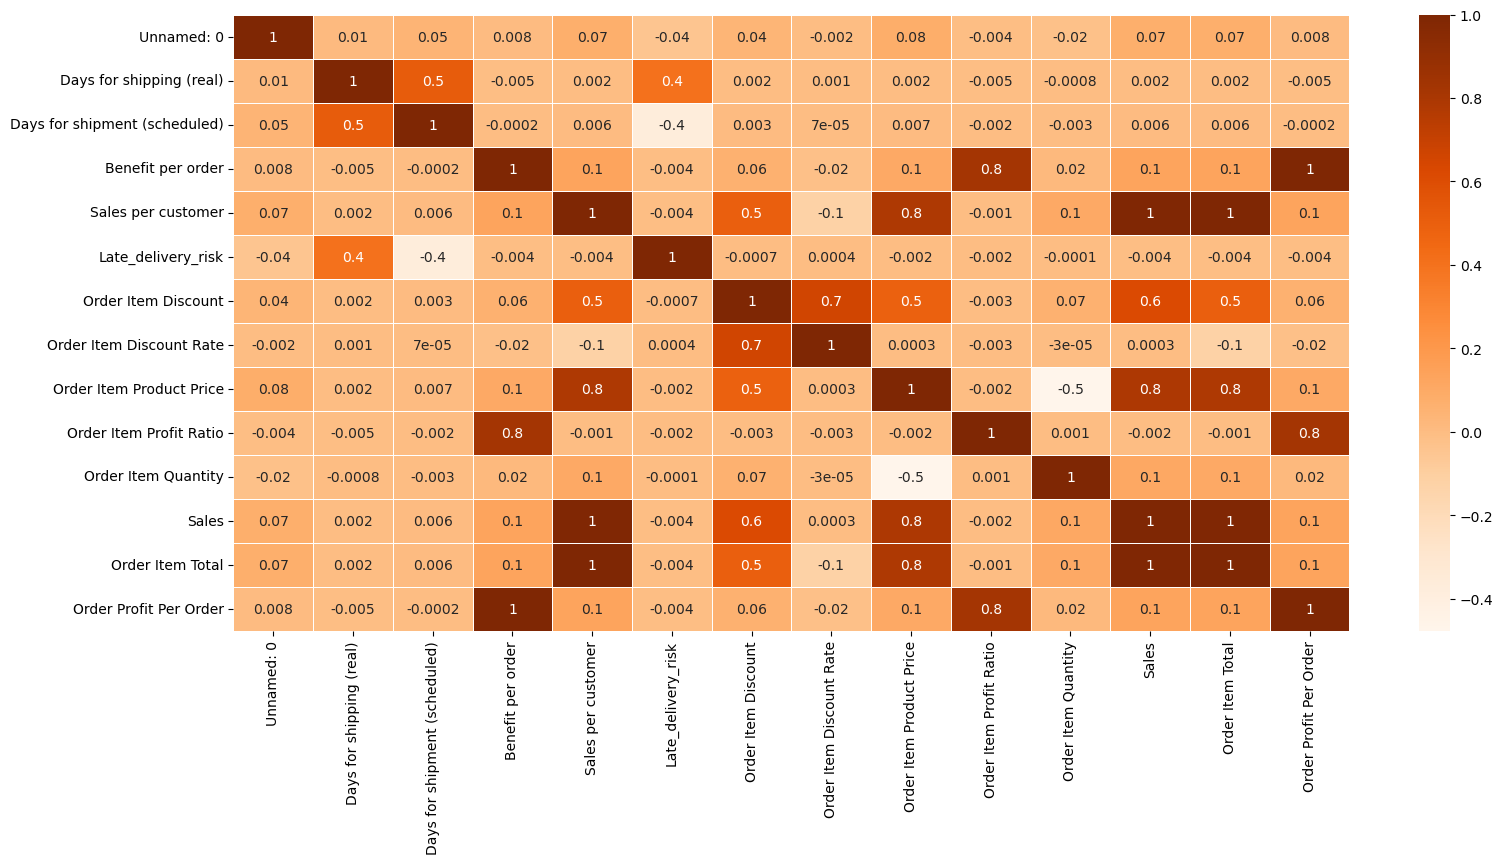

In [60]:
# Correlação
fig, ax = plt.subplots(figsize = (18,8))    
sns.heatmap(dados.corr(), annot = True, linewidths = .5, fmt = '.1g', cmap = 'Oranges') 

In [61]:
# Drop de colunas
dados = dados.drop(['Unnamed: 0', 'Order Item Discount Rate'], axis = 1)

<AxesSubplot:>

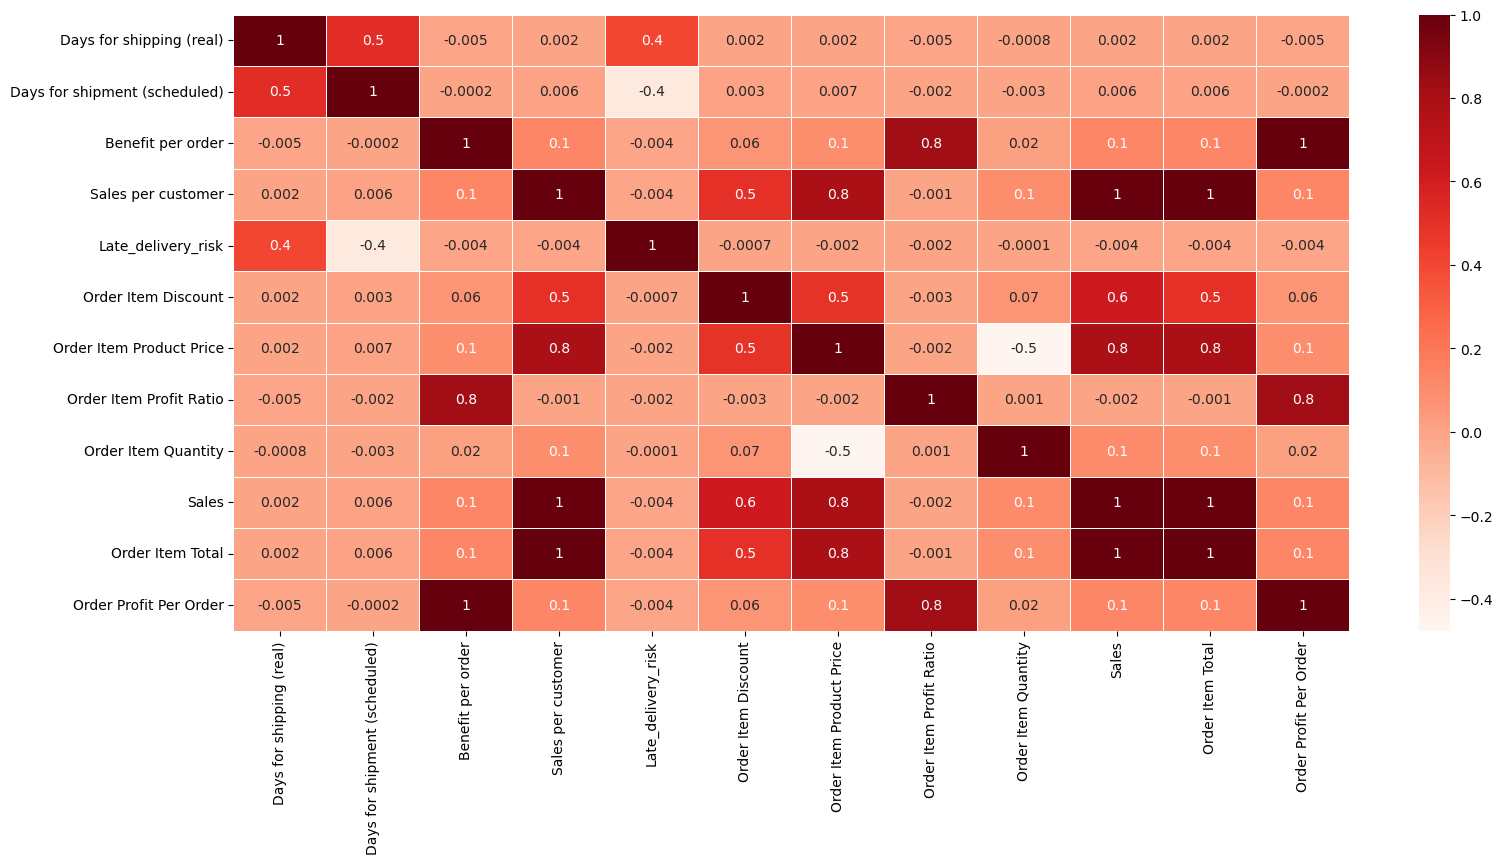

In [62]:
# Correlação
fig, ax = plt.subplots(figsize = (18,8))    
sns.heatmap(dados.corr(), annot = True, linewidths = .5, fmt = '.1g', cmap = 'Reds') 

### Criação e Avaliação do Modelo

In [63]:
# Sessão
spark = SparkSession.builder.appName("Modelo_DSA").getOrCreate()

23/10/07 15:56:53 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [64]:
# Converte o dataframe do pandas para dataframe do Spark
df_suppply_chain = spark.createDataFrame(dados) 

In [65]:
# Visualiza
df_suppply_chain.show(5)

23/10/07 15:57:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/10/07 15:57:14 WARN TaskSetManager: Stage 11 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


23/10/07 15:57:18 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 11 (TID 10): Attempting to kill Python Worker
+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+--------------+-------------+----------------+----------------+--------------+---------------+------------+----------+-------------+-----------------------+-------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+------------+--------------+----------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer| Delivery Status|Late_delivery_risk| Category Name|Customer City|Customer Country|Customer Segment|Customer State|Department Name|      Market|Order City|Order Country|order date (DateOrders)|Order Item Discount|Order Item Product Price|Or

In [66]:
# Tipos de dados
df_suppply_chain.dtypes

[('Type', 'string'),
 ('Days for shipping (real)', 'bigint'),
 ('Days for shipment (scheduled)', 'bigint'),
 ('Benefit per order', 'double'),
 ('Sales per customer', 'double'),
 ('Delivery Status', 'string'),
 ('Late_delivery_risk', 'bigint'),
 ('Category Name', 'string'),
 ('Customer City', 'string'),
 ('Customer Country', 'string'),
 ('Customer Segment', 'string'),
 ('Customer State', 'string'),
 ('Department Name', 'string'),
 ('Market', 'string'),
 ('Order City', 'string'),
 ('Order Country', 'string'),
 ('order date (DateOrders)', 'string'),
 ('Order Item Discount', 'double'),
 ('Order Item Product Price', 'double'),
 ('Order Item Profit Ratio', 'double'),
 ('Order Item Quantity', 'bigint'),
 ('Sales', 'double'),
 ('Order Item Total', 'double'),
 ('Order Profit Per Order', 'double'),
 ('Order Region', 'string'),
 ('Order State', 'string'),
 ('Order Status', 'string'),
 ('Product Name', 'string'),
 ('Shipping Mode', 'string'),
 ('Customer Name', 'string')]

In [67]:
# Cria uma lista para converter as strings para o tipo double (encoding) e criar o indexador 
indexers = [StringIndexer(inputCol = "Delivery Status", outputCol = "Status"), 
            StringIndexer(inputCol = "Type", outputCol = "type"), 
            StringIndexer(inputCol = "Category Name", outputCol = "Category_Name"), 
            StringIndexer(inputCol = "Customer Segment", outputCol = "Customer_Segment"), 
            StringIndexer(inputCol = "Department Name", outputCol = "Department_Name"),
            StringIndexer(inputCol = "Late_delivery_risk", outputCol = "Risk", stringOrderType = 'frequencyAsc'),
            StringIndexer(inputCol = "Order Region", outputCol = "region"),
            StringIndexer(inputCol = "Market", outputCol = "market")]

In [68]:
type(indexers)

list

In [69]:
# Cria o pipeline
pipeline = Pipeline(stages = indexers)

In [70]:
type(pipeline)

pyspark.ml.pipeline.Pipeline

In [71]:
# Fit e transform do pipeline
indexed_df_suppply_chain = pipeline.fit(df_suppply_chain).transform(df_suppply_chain) 

23/10/07 15:57:18 WARN TaskSetManager: Stage 12 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


23/10/07 15:57:19 WARN TaskSetManager: Stage 15 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.
23/10/07 15:57:19 WARN TaskSetManager: Stage 18 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.
23/10/07 15:57:20 WARN TaskSetManager: Stage 21 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.
23/10/07 15:57:20 WARN TaskSetManager: Stage 24 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.
23/10/07 15:57:21 WARN TaskSetManager: Stage 27 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.
23/10/07 15:57:21 WARN TaskSetManager: Stage 30 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.
23/10/07 15:57:21 WARN TaskSetManager: Stage 33 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.

In [72]:
type(indexed_df_suppply_chain)

pyspark.sql.dataframe.DataFrame

In [73]:
# Visualiza
indexed_df_suppply_chain.show(5, False)

23/10/07 15:57:22 WARN TaskSetManager: Stage 36 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


23/10/07 15:57:26 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 36 (TID 27): Attempting to kill Python Worker
+----+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+--------------+-------------+----------------+----------------+--------------+---------------+------+----------+-------------+-----------------------+-------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+------------+--------------+----------------+------+-------------+----------------+---------------+----+------+
|type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status |Late_delivery_risk|Category Name |Customer City|Customer Country|Customer Segment|Customer State|Department Name|market|Order City|Order Country|order date (DateOrders)|O

In [74]:
# Cria a coluna de features (atributos) que serão indexadas
# Nota: Essas são as variáveis de entrada
vectorAssembler = VectorAssembler(inputCols = ['type',
                                               'Days for shipping (real)',
                                               'region',
                                               'Customer_Segment',
                                               'Department_Name'],
                                  outputCol = "features")

In [75]:
type(vectorAssembler)

pyspark.ml.feature.VectorAssembler

In [76]:
# Cria o dataframe
vindexed_df_suppply_chain = vectorAssembler.transform(indexed_df_suppply_chain)

In [77]:
# Visualiza
vindexed_df_suppply_chain.show(5, False)

23/10/07 15:57:26 WARN TaskSetManager: Stage 37 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


23/10/07 15:57:30 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 37 (TID 28): Attempting to kill Python Worker
+----+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+--------------+-------------+----------------+----------------+--------------+---------------+------+----------+-------------+-----------------------+-------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+------------+--------------+----------------+------+-------------+----------------+---------------+----+------+---------------------+
|type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status |Late_delivery_risk|Category Name |Customer City|Customer Country|Customer Segment|Customer State|Department Name|market|Order City|Order Country|ord

In [78]:
# Drop de colunas não usadas
vindexed_df_suppply_chain = vindexed_df_suppply_chain.drop('type',
                                                           'Days for shipping (real)',
                                                           'Days for shipment (scheduled)',
                                                           'Sales per customer',
                                                           'Benefit per order',
                                                           'Status',
                                                           'ship_mode',
                                                           'Customer Segment',
                                                           'Customer City',
                                                           'Delivery Status',
                                                           'Category Name',
                                                           'Category_Name',
                                                           'Customer_Segment',
                                                           'Department_Name',
                                                           'market')

In [79]:
# Visualiza
vindexed_df_suppply_chain.show(5, False)

23/10/07 15:57:30 WARN TaskSetManager: Stage 38 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


23/10/07 15:57:34 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 38 (TID 29): Attempting to kill Python Worker
+------------------+----------------+--------------+---------------+----------+-------------+-----------------------+-------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+------------+--------------+----------------+----+------+---------------------+
|Late_delivery_risk|Customer Country|Customer State|Department Name|Order City|Order Country|order date (DateOrders)|Order Item Discount|Order Item Product Price|Order Item Profit Ratio|Order Item Quantity|Sales |Order Item Total|Order Profit Per Order|Order Region  |Order State    |Order Status   |Product Name|Shipping Mode |Customer Name   |Risk|region|features             |
+------------------+----------------+--------------+---------------+----------+-------------+-----------

In [80]:
vindexed_df_suppply_chain.columns

['Late_delivery_risk',
 'Customer Country',
 'Customer State',
 'Department Name',
 'Order City',
 'Order Country',
 'order date (DateOrders)',
 'Order Item Discount',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'Order Item Total',
 'Order Profit Per Order',
 'Order Region',
 'Order State',
 'Order Status',
 'Product Name',
 'Shipping Mode',
 'Customer Name',
 'Risk',
 'region',
 'features']

In [81]:
# Prepara o dataset final
dataset_final = vindexed_df_suppply_chain.drop('Customer Country',
                                               'Customer State',
                                               'Department Name',
                                               'Order City',
                                               'region',
                                               'Order Country',
                                               'order date (DateOrders)',
                                               'Order Item Discount',
                                               'Late_delivery_risk',
                                               'Order Item Product Price',
                                               'Order Item Profit Ratio',
                                               'Order Item Quantity',
                                               'Sales',
                                               'Order Item Total',
                                               'Order Profit Per Order',
                                               'Order Region',
                                               'Order State',
                                               'Order Status',
                                               'Product Name',
                                               'Shipping Mode',
                                               'Customer Name')

In [82]:
# Visualiza
dataset_final.show(5, False)

23/10/07 15:57:35 WARN TaskSetManager: Stage 39 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


23/10/07 15:57:39 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 39 (TID 30): Attempting to kill Python Worker
+----+---------------------+
|Risk|features             |
+----+---------------------+
|0.0 |[0.0,3.0,5.0,0.0,5.0]|
|1.0 |[1.0,5.0,9.0,0.0,5.0]|
|0.0 |[3.0,4.0,9.0,0.0,5.0]|
|0.0 |[0.0,3.0,3.0,2.0,5.0]|
|0.0 |[2.0,2.0,3.0,1.0,5.0]|
+----+---------------------+
only showing top 5 rows



A coluna Risk é a variável target e a coluna features é um vetor contendo a indexação das variáveis de entrada.

### Treinamento do Modelo

https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier

In [83]:
# Divide os dados em treino e teste
(dados_treino, dados_teste) = dataset_final.randomSplit([0.8, 0.2], 42)

In [84]:
dados_treino

DataFrame[Risk: double, features: vector]

In [85]:
dados_treino.printSchema()

root
 |-- Risk: double (nullable = false)
 |-- features: vector (nullable = true)



In [86]:
# Cria o modelo
obj_modelo = DecisionTreeClassifier(labelCol = "Risk", 
                                    featuresCol = "features", 
                                    impurity = 'gini')

In [87]:
# Treina o modelo
modelo_v1 = obj_modelo.fit(dados_treino)

23/10/07 15:57:39 WARN TaskSetManager: Stage 40 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


23/10/07 15:57:40 WARN TaskSetManager: Stage 41 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


23/10/07 15:57:41 WARN TaskSetManager: Stage 42 contains a task of very large size (29306 KiB). The maximum recommended task size is 1000 KiB.
23/10/07 15:57:41 WARN TaskSetManager: Stage 44 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


23/10/07 15:57:42 WARN TaskSetManager: Stage 46 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.
23/10/07 15:57:42 WARN TaskSetManager: Stage 48 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.
23/10/07 15:57:42 WARN TaskSetManager: Stage 50 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.
23/10/07 15:57:42 WARN TaskSetManager: Stage 52 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


In [88]:
# Previsões com dados de teste
previsoes = modelo_v1.transform(dados_teste)

In [89]:
# Visualiza
previsoes.show(10, False)

23/10/07 15:57:43 WARN TaskSetManager: Stage 54 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.
+----+---------+-------------+-----------+----------+
|Risk|features |rawPrediction|probability|prediction|
+----+---------+-------------+-----------+----------+
|0.0 |(5,[],[])|[4023.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])|[4023.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])|[4023.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])|[4023.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])|[4023.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])|[4023.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])|[4023.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])|[4023.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])|[4023.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])|[4023.0,0.0] |[1.0,0.0]  |0.0       |
+----+---------+-------------+-----------+----------+
only showing top 10 rows



### Avaliação do Modelo

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html

In [90]:
# Cria o avaliador
avaliador = MulticlassClassificationEvaluator(labelCol = "Risk", 
                                              predictionCol = "prediction", 
                                              metricName  = "accuracy")

In [91]:
# Calcula a acurácia
acc = avaliador.evaluate(previsoes)

23/10/07 15:57:43 WARN TaskSetManager: Stage 55 contains a task of very large size (29305 KiB). The maximum recommended task size is 1000 KiB.


In [92]:
print("Acurácia do Modelo = %g " % (acc))

Acurácia do Modelo = 0.764784 


In [93]:
print('Árvore do Modelo de Classificação:\n')
print(modelo_v1.toDebugString)

Árvore do Modelo de Classificação:

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_8d03f1af7f8c, depth=4, numNodes=9, numClasses=2, numFeatures=5
  If (feature 1 <= 4.5)
   If (feature 1 <= 2.5)
    If (feature 1 <= 0.5)
     Predict: 0.0
    Else (feature 1 > 0.5)
     If (feature 1 <= 1.5)
      Predict: 1.0
     Else (feature 1 > 1.5)
      Predict: 0.0
   Else (feature 1 > 2.5)
    Predict: 0.0
  Else (feature 1 > 4.5)
   Predict: 1.0



# Fim